In [13]:
from pathlib import Path
from collections import defaultdict
from typing import Dict, List
import os
import sys

import numpy as np
import pandas as pd
import pretty_midi
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

# adding preprocessing directory to path
current_dir = os.path.dirname(os.path.abspath("preprocessing"))
parent_dir = os.path.join(current_dir, '..')
sys.path.append(parent_dir)

from preprocessing.audio_to_spectrogram import midi_track_length

sns.set_theme()

### Note Count Analysis (per Composer & Piece)


In [ ]:
def count_notes(file_path: Path) -> int:
    """
    Return the number of pitched notes in the FIRST non-drum instrument.
    If file can't be parsed, we log and return 0.
    """
    try:
        midi = pretty_midi.PrettyMIDI(str(file_path))

        # Find the first non-drum instrument that actually has notes.
        for instrument in midi.instruments:
            if not instrument.is_drum and instrument.notes:
                return len(instrument.notes)

        # If we got here, either there were only drums or no notes at all.
        return 0

    except Exception as e:
        # Keep going even if one file is messy or corrupt.
        print(f"Error reading {file_path}: {e}")
        return 0

# analysis of note counts
dataset_folder = Path("../data/midi/")
target_composers = ["Bach", "Beethoven", "Chopin", "Mozart"]

# A dict like {"Bach": [count1, count2, ...], ...}
note_counts: Dict[str, List[int]] = defaultdict(list)

#Scan folders and count notes per file 
for composer in target_composers:
    composer_folder = dataset_folder / composer
    # Grab both .mid and .midi files (recursive), then sort for repeatability.
    midi_files = sorted(
        list(composer_folder.rglob("*.mid")) + list(composer_folder.rglob("*.midi"))
    )

    for file_path in tqdm(midi_files, desc=f"Processing {composer}"):
        n = count_notes(file_path)
        if n > 0:  # ignore empty/invalid files so stats aren't skewed by zeros
            note_counts[composer].append(n)

# Print summary stats
for composer, counts in note_counts.items():
    counts_arr = np.asarray(counts)
    if counts_arr.size == 0:
        print(f"\n{composer}: 0 usable files")
        continue

    print(f"\n{composer}: {counts_arr.size} files")
    print(f"  Min notes: {counts_arr.min()}")
    print(f"  Max notes: {counts_arr.max()}")
    print(f"  Mean notes: {counts_arr.mean():.1f}")
    print(f"  Median notes: {np.median(counts_arr):.1f}")

Processing Bach:  53%|█████▎    | 494/925 [00:05<00:09, 45.01it/s] /opt/anaconda3/envs/dl_final_project/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing Beethoven:   5%|▍         | 10/213 [00:00<00:07, 28.48it/s]

Error reading ../data/midi/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Mozart:  19%|█▉        | 50/257 [00:02<00:11, 17.26it/s]

Error reading ../data/midi/Mozart/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Processing Mozart: 100%|██████████| 257/257 [00:28<00:00,  8.88it/s]


Bach: 925 files
  Min notes: 9
  Max notes: 17389
  Mean notes: 387.6
  Median notes: 97.0

Beethoven: 212 files
  Min notes: 16
  Max notes: 9912
  Mean notes: 1549.5
  Median notes: 1060.0

Chopin: 136 files
  Min notes: 61
  Max notes: 8865
  Mean notes: 1466.6
  Median notes: 928.0

Mozart: 256 files
  Min notes: 51
  Max notes: 8980
  Mean notes: 1181.7
  Median notes: 625.5


### Note-Count Distributions (per Composer)


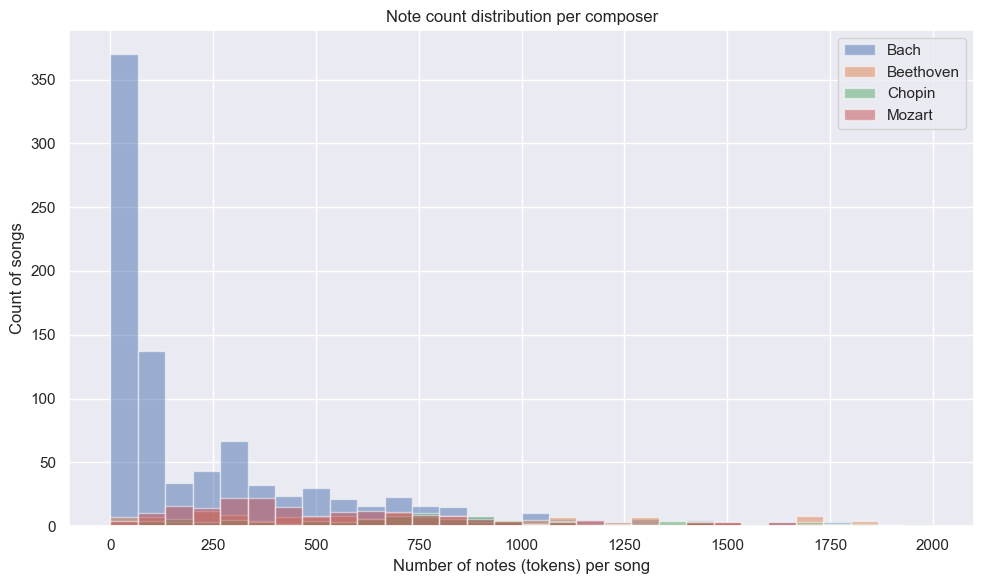

In [6]:
#Plot distributions per composer 
plt.figure(figsize=(10, 6))
for composer, counts in note_counts.items():
    if counts:  # only plot if we have data
        plt.hist(counts, bins=30, alpha=0.5, label=composer, range=(0,2000))

plt.xlabel("Number of notes (tokens) per song")
plt.ylabel("Count of songs")
plt.title("Note count distribution per composer")
plt.legend()
plt.tight_layout()
plt.show() 

### Track Duration Analyses

In [21]:
base_midi_path = r"../data/midi/"
sub_dirs = ["Bach", "Beethoven", "Chopin", "Mozart"]
track_lengths = []

# loop through each composer directory
for dir in sub_dirs:
    path = f"{base_midi_path}{dir}/"
    files = os.listdir(path)

    for file in files:
        file_path = path + file
        try:
            track_lengths.append((dir, file, midi_track_length(file_path)))
        except Exception as e:
            print(e)
            print(file_path)

MThd not found. Probably not a MIDI file
../data/midi/Bach/readme
Could not decode key with 3 flats and mode 255
../data/midi/Beethoven/Anhang 14-3.mid
Could not decode key with 2 flats and mode 2
../data/midi/Mozart/K281 Piano Sonata n03 3mov.mid


In [24]:
track_lengths_df = pd.DataFrame(track_lengths, columns=["composer", "file", "length"])
track_lengths_df.groupby("composer")["length"].sum()/3600

composer
Bach         44.720578
Beethoven    31.414792
Chopin        8.356854
Mozart       28.512761
Name: length, dtype: float64

In [27]:
track_lengths_df[track_lengths_df["composer"]
                 == "Bach"].sort_values("length", axis=0, ascending=False)

,composer,file,length
815,Bach,The Art of the Fugue BWV1080.mid,5209.310787
940,Bach,Bwv1052 Harpsichord Concerto n1b.mid,1341.465240
162,Bach,Bwv1050 Brandenburg Concert n5 1-2-3movs.MID,1271.383007
321,Bach,Bwv0816 French Suite n5.mid,1179.419324
376,Bach,Bwv0815 French Suite n4.mid,1152.905274
...,...,...,...
244,Bach,028100b_.mid,21.875000
866,Bach,016506b_.mid,21.600586
636,Bach,006206bv.mid,20.000000
6,Bach,006206b_.mid,20.000000


In [36]:
track_lengths_df.groupby("composer").describe().apply(lambda x: x.apply(lambda x: format(x, ".0f")))

length                                   
           count mean  std min  25%  50%  75%   max
composer                                           
Bach        1024  157  246  18   43   77  191  5209
Beethoven    219  516  489  22  226  415  676  5032
Chopin       136  221  185  23   93  158  312  1353
Mozart       256  401  273  26  207  348  530  1478

In [33]:
track_lengths_df[track_lengths_df["composer"]=="Bach"]["length"].max()

5209.31078725735